In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, regularizers
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2 as cv
import matplotlib.pyplot as plt
import os
import shutil
from sklearn.model_selection import train_test_split
import keras_tuner as kt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


CLASSES = 2
BATCH_SIZE = 16

tf.random.set_seed(123)
np.random.seed(123)


In [11]:
def read_label_file(label_file):
    data = []
    with open(label_file, 'r', encoding='utf-8') as f:
        for line in f:
            # Split each line by space (assuming space-separated values)
            parts = line.strip().split()
            # Extract relevant information from the line
            image_path = parts[0]  # Assuming the image path is the first item
            # Assuming the rest of the items in the line are label values
            labels = parts[1:]
            # Append the extracted information as a tuple to the data list
            data.append((image_path, *labels))
    # Convert the data list to a pandas DataFrame
    df = pd.DataFrame(data)  
    return df

# Read Train Labels
label_file = '../../Drowsey_Driver_DL_Data/combined_classification_dataset/combined_train_labels.txt'
train_df = read_label_file(label_file)
train_df.drop(train_df.columns[1], axis=1, inplace=True)
train_df.columns = ["Image_path", 'label_x', 'label_y', 'label_w', 'label_h', 'class']
print(train_df.head())  # Display the first few rows of the DataFrame

# Split the combined train dataframe into train and validation sets
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

print(val_df.head())

# Read Test Labels
label_file = '../../Drowsey_Driver_DL_Data/combined_classification_dataset/combined_test_labels.txt'
test_df = read_label_file(label_file)
test_df.drop(test_df.columns[1], axis=1, inplace=True)
test_df.columns = ["Image_path", 'label_x', 'label_y', 'label_w', 'label_h', 'class']
print(test_df.head())  # Display the first few rows of the DataFrame

                                          Image_path     label_x     label_y  \
0  frame_0149_jpg.rf.ad848af69b7adc7a4d67f8d82b92...      0.6625  0.15390625   
1  frame_0161_jpg.rf.a7d9f87c6556f2d980a350eb857d...  0.72265625    0.190625   
2  frame_0077_jpg.rf.33fd47b720cd708a804198f25d15...  0.40078125  0.34765625   
3  frame_0063_jpg.rf.4624fa9ce940d4a3064911fcb3ce...  0.42578125      0.3375   
4  frame_0175_jpg.rf.c07c9544bfd1df4e226182f80058...  0.77109375  0.24296875   

      label_w     label_h class  
0    0.246875   0.2265625     1  
1       0.225  0.24609375     1  
2  0.47578125   0.0984375     0  
3   0.4109375   0.1609375     0  
4     0.29375   0.3109375     1  
                                            Image_path     label_x  \
767  frame_0077_jpg.rf.3a66aface3c9af519f2ca0fd1a0e...    0.478125   
70   frame_0061_jpg.rf.cfa87e213bfb60d9a8c9327dca5b...   0.4078125   
855  frame_0028_jpg.rf.19e32f8b894307391def3413c3d1...  0.81484375   
485  frame_0191_jpg.rf.e7f6ac183ee8

In [12]:
train_df

,Image_path,label_x,label_y,label_w,label_h,class
825,frame_0121_jpg.rf.f37f9a1d112f9f10da4c183f238f...,0.46796875,0.52265625,0.42890625,0.0734375,0
621,frame_0014_jpg.rf.37dae33a90d67e8d9641deac08e6...,0.47890625,0.51953125,0.4046875,0.1140625,0
529,frame_0220_jpg.rf.03c2eee10097776806a914cd5bed...,0.54453125,0.27265625,0.1328125,0.16875,0
398,frame_0225_jpg.rf.8ce65e178d0c585838cb57a21dc4...,0.49140625,0.26484375,0.1734375,0.196875,0
235,frame_0161_jpg.rf.2f8c007fe4c291caa38e6a95b4cb...,0.75390625,0.215625,0.25,0.26875,1
...,...,...,...,...,...,...
106,frame_0029_jpg.rf.1e09b74824f6ebb718e711a0a03b...,0.6203125,0.234375,0.2703125,0.184375,0
270,frame_0188_jpg.rf.5a8cbde50aa511468281ffa2edfa...,0.71328125,0.18984375,0.2265625,0.265625,1
860,frame_0022_jpg.rf.a666ebdc0b31104a8ec23adb88da...,0.521875,0.27890625,0.3265625,0.159375,0
435,frame_0194_jpg.rf.d8ea56d7856bacab11616a91a414...,0.53828125,0.353125,0.14453125,0.1703125,1


In [20]:
import cv2

def preprocess_image_and_label_train(image_name, label_x, label_y, label_w, label_h, class_label, target_size=(244, 244)):
    # Construct the full image path
    image_path = os.path.join('/Users/sameeraboppana/Desktop/DL_Project/combined_classification_dataset/train/images', image_name)
    
    # Read and preprocess the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to load image from {image_path}")
        return None, None
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width, _ = image.shape
    x, y, w, h = int(float(label_x) * width), int(float(label_y) * height), int(float(label_w) * width), int(float(label_h) * height)
    cropped_image = image[y:y+h, x:x+w]
    cropped_image = cv2.resize(cropped_image, target_size)
    
    # Preprocess the class label
    class_label = int(class_label)  # Convert to integer
    
    return cropped_image, class_label

# Lists to store preprocessed images and their corresponding class labels
train_preprocessed_images = []
train_class_labels = []

# Iterate through each row in train_df and preprocess the images and labels
for index, row in train_df.iterrows():
    image_name = row['Image_path']  # Assuming this contains just the image filename
    label_x = row['label_x']
    label_y = row['label_y']
    label_w = row['label_w']
    label_h = row['label_h']
    class_label = row['class']

    # Preprocess the image and label
    image, class_label = preprocess_image_and_label_train(image_name, label_x, label_y, label_w, label_h, class_label)
    
    # Append preprocessed image and class label to lists
    train_preprocessed_images.append(image)
    train_class_labels.append(class_label)

In [15]:
from sklearn.model_selection import train_test_split

# Further split the training data into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(train_preprocessed_images, train_class_labels, test_size=0.1, random_state=42)

# Optionally, convert the lists to numpy arrays for compatibility with TensorFlow/Keras
import numpy as np
train_images = np.array(train_images)
val_images = np.array(val_images)
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

# Print the shapes of the train and validation sets
print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)
print("Validation images shape:", val_images.shape)
print("Validation labels shape:", val_labels.shape)


Train images shape: (786, 244, 244, 3)
Train labels shape: (786,)
Validation images shape: (88, 244, 244, 3)
Validation labels shape: (88,)


In [16]:
import keras_tuner as kt
from tensorflow.keras import layers, models, regularizers

# Define your CNN model architecture
def build_model(hp):
    model = models.Sequential()
    
    # Convolutional layers with varying number of filters
    model.add(layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
        activation='relu',
        input_shape=(244, 244, 3),  # Adjust input shape according to your preprocessed image size
        kernel_regularizer=regularizers.l2(0.001)
    ))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=64, max_value=128, step=32),
        kernel_size=hp.Choice('conv_2_kernel', values=[3, 5]),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(
        filters=hp.Int('conv_3_filter', min_value=128, max_value=256, step=32),
        kernel_size=hp.Choice('conv_3_kernel', values=[3, 5]),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(
        units=hp.Int('dense_units', min_value=64, max_value=256, step=32),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ))
    model.add(layers.Dropout(rate=hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
    
    model.add(layers.Dense(1, activation='sigmoid'))  # Assuming binary classification, adjust if needed
    
    model.compile(
        optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop']),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model


# Initialize Keras Tuner RandomSearch
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Number of hyperparameter combinations to try
    directory='my_dir',
    project_name='random_search'
)

# Run the hyperparameter search
tuner.search(train_images, train_labels, epochs=10, validation_data=(val_images, val_labels))



Trial 10 Complete [00h 01m 15s]
val_accuracy: 0.5795454382896423

Best val_accuracy So Far: 0.9431818127632141
Total elapsed time: 00h 18m 10s


In [24]:
test_preprocessed_images = []
test_class_labels = []

def preprocess_image_and_label_test(image_name, label_x, label_y, label_w, label_h, class_label, target_size=(244, 244)):
    # Construct the full image path
    image_path = os.path.join('/Users/sameeraboppana/Desktop/DL_Project/combined_classification_dataset/test/images', image_name)
    
    # Read and preprocess the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to load image from {image_path}")
        return None, None
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width, _ = image.shape
    x, y, w, h = int(float(label_x) * width), int(float(label_y) * height), int(float(label_w) * width), int(float(label_h) * height)
    cropped_image = image[y:y+h, x:x+w]
    cropped_image = cv2.resize(cropped_image, target_size)
    
    # Preprocess the class label
    class_label = int(class_label)  # Convert to integer
    
    return cropped_image, class_label


# Iterate through each row in test_df and preprocess the images and labels
for index, row in test_df.iterrows():
    image_name = row['Image_path']  # Assuming this contains just the image filename
    label_x = row['label_x']
    label_y = row['label_y']
    label_w = row['label_w']
    label_h = row['label_h']
    class_label = row['class']

    # Preprocess the image and label
    image, class_label = preprocess_image_and_label_test(image_name, label_x, label_y, label_w, label_h, class_label)
    
    # Append preprocessed image and class label to lists
    test_preprocessed_images.append(image)
    test_class_labels.append(class_label)


In [29]:
# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Train the best model on the combined train and validation data
best_model.fit(train_images, train_labels, epochs=10, validation_data=(val_images, val_labels))

# Convert test_preprocessed_images and test_class_labels to numpy arrays
test_images = np.array(test_preprocessed_images)
test_labels = np.array(test_class_labels)

# Evaluate the best model on the test data
test_loss, test_accuracy = best_model.evaluate(test_images, test_labels)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 18s 494ms/step - accuracy: 0.7221 - loss: 2.1068 - val_accuracy: 0.6364 - val_loss: 2.2237
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 477ms/step - accuracy: 0.7366 - loss: 0.8845 - val_accuracy: 0.8409 - val_loss: 0.5912
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 467ms/step - accuracy: 0.8000 - loss: 0.9185 - val_accuracy: 0.7386 - val_loss: 0.6779
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 844ms/step - accuracy: 0.7773 - loss: 0.6957 - val_accuracy: 0.7273 - val_loss: 0.7257
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 467ms/step - accuracy: 0.7633 - loss: 0.8646 - val_accuracy: 0.7614 - val_loss: 0.7202
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 473ms/step - accuracy: 0.7694 - loss: 0.8430 - val_accuracy: 0.9091 - val_loss: 0.4550
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 779ms/step - accuracy: 0.8404 - loss: 0.5625 - val_accuracy: 0.9091 - val_loss: 0.5032
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 491ms/step - accuracy: 0.8565 - loss: 0.5327 - val_accu

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
Actual Label: 0 Predicted Label: [0]
Actual Label: 0 Predicted Label: [0]
Actual Label: 0 Predicted Label: [0]
Actual Label: 1 Predicted Label: [1]
Actual Label: 1 Predicted Label: [1]
Actual Label: 0 Predicted Label: [0]
Actual Label: 1 Predicted Label: [0]
Actual Label: 1 Predicted Label: [0]
Actual Label: 0 Predicted Label: [0]
Actual Label: 0 Predicted Label: [0]


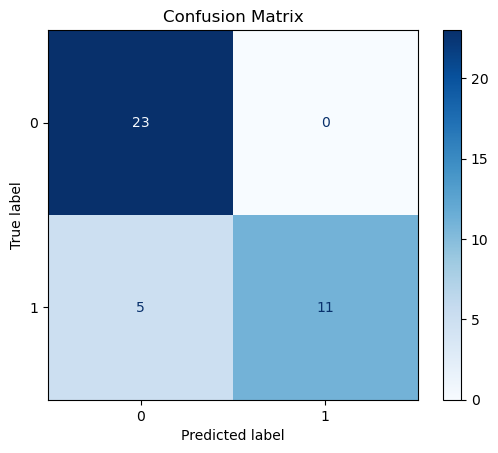

In [32]:
# Make predictions on the test data
predictions = best_model.predict(test_images)

# Convert predictions to class labels (assuming binary classification)
predicted_labels = (predictions > 0.5).astype(int)

# Display some predictions
for i in range(10):  # Displaying predictions for the first 10 samples
    print("Actual Label:", test_labels[i], "Predicted Label:", predicted_labels[i])


# Compute the confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)

# Plot the confusion matrix
def plot_confusion_matrix(cm):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(test_labels))
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

# Plot the confusion matrix
plot_confusion_matrix(cm)


In [43]:
new_image_path = "/Users/sameeraboppana/Desktop/DL_Project/PHOTO-2024-05-29-19-11-53.jpg"

# Read the new image
new_image = cv2.imread(new_image_path)
if new_image is None:
    print(f"Error: Unable to load image from {new_image_path}")
else:
    # Preprocess the new image (resize, normalize, etc.)
    preprocessed_new_image = cv2.resize(new_image, (244, 244))  # Resize to match the input size of your model
    
    # Make prediction on the preprocessed new image
    prediction = model.predict(np.expand_dims(preprocessed_new_image, axis=0))
    
    # Convert prediction to class label
    predicted_label = np.argmax(prediction)
    
    print("Predicted label for the new image:", predicted_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted label for the new image: 0
